# Example: Training LSTM model with new data

In this example we'll train the LSTM model to generate abundance predictions from Mean Temperature, Precipitation, and Humidity.

We start by loading necessary packages:

In [2]:
import tensorflow as tf
import os, json, joblib
import pandas as pd, numpy as np
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.append("./utils")
sys.path.append("./models")
sys.path.append("./results")
from predictions import *
from performance_metrics import *

import pdb
#Packages to plot
from datetime import datetime, timedelta
import chart_studio.plotly as py
import plotly.graph_objects as go
from plotly.offline import iplot

## Update data file

Here we use the same training, validation, and testing data, but instead of min_temp and max_temp we use avg_temp. We only need to run this cell once.

In [3]:
## Set data files
data_files=["./data/train_data.pd","./data/val_data.pd","./data/test_data.pd"]
for data_file in data_files:
    #load data and replace min_temp and max_temp with avg_temp
    data=pd.read_pickle(data_file)
    data["Avg_Temp"]=data[['Min_Temp','Max_Temp']].mean(axis=1)
    data.drop(columns=['Min_Temp', 'Max_Temp'],inplace=True)
    #Reorder columns correctly
    data=data[['Location', 'Year', 'Month', 'Day', 'Avg_Temp', 'Precip','Humidity', 'MoLS']]
    #Ensure indices start at 0
    data=data.reset_index(drop=True)
    data.to_pickle(data_file.split('_data')[0]+"_avg_data.pd")


## Create new config file

Here samples are 90x3 and we update the file paths. We only need to run this cell once.

In [4]:
with open('./models/configs/lstm_config.json', 'r+') as fp:
    data = json.load(fp)
    data['data']['data_shape']=[90,3]
    data['files']['model']='./models/saved_models/lstm_avg_temp.h5'
    data['files']['training']='./data/train_avg_data.pd'
    data['files']['validation']='./data/val_avg_data.pd'
    data['files']['testing']='./data/test_avg_data.pd'
with open('./models/configs/lstm_avg_temp_config.json', 'w') as fp:
    json.dump(data,fp)

## Train model

Here we train using the command line arguments. Add arguments **-l** to load a previously trained model instead of training a new one and **-t** to run the testing dataset.

1 Physical GPUs, 1 Logical GPUs
(115000, 90, 4)
(115000, 90, 4)
(29000, 90, 4)
Epoch 1/100
1797/1797 [==============================] - 44s 18ms/step - loss: 0.0041 - r2_keras: 0.7893 - val_loss: 0.0022 - val_r2_keras: 0.9114
Epoch 2/100
1797/1797 [==============================] - 30s 17ms/step - loss: 0.0023 - r2_keras: 0.9085 - val_loss: 0.0019 - val_r2_keras: 0.8958
Epoch 3/100
1797/1797 [==============================] - 29s 16ms/step - loss: 0.0018 - r2_keras: 0.9157 - val_loss: 0.0013 - val_r2_keras: 0.9232
Epoch 4/100
1797/1797 [==============================] - 30s 16ms/step - loss: 0.0015 - r2_keras: 0.9199 - val_loss: 0.0010 - val_r2_keras: 0.9385
Epoch 5/100
1797/1797 [==============================] - 29s 16ms/step - loss: 0.0011 - r2_keras: 0.9303 - val_loss: 8.8366e-04 - val_r2_keras: 0.9384
Epoch 6/100
1797/1797 [==============================] - 29s 16ms/step - loss: 9.9785e-04 - r2_keras: 0.9315 - val_loss: 7.1378e-04 - val_r2_keras: 0.9460
Epoch 7/100
1797/1797 [====

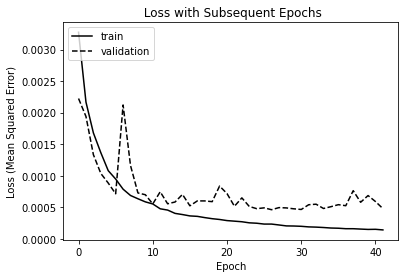

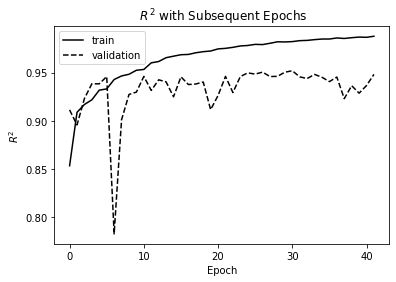

In [5]:
%run -i "./models/training.py" "./models/configs/lstm_avg_temp_config.json"

## Generate and save predictions

We generate the results for both the training and testing sets and save as csv files.

In [12]:
config_file="./models/configs/lstm_avg_temp_config.json"
with open(config_file, 'r+') as fp:
    config = json.load(fp)

data_files=[config['files']['training'], config['files']['testing']]
data_shape=config['data']['data_shape']

for data_file in data_files:
    data=pd.read_pickle(data_file)
    if os.path.exists(config['files']['model']):
        model=tf.keras.models.load_model(config['files']['model'], custom_objects={"r2_keras":r2_keras})
        if 'train' in data_file:
            results, scaler=gen_preds(model, data, data_shape, None, fit_scaler=True)
            pd.DataFrame(results, columns=['Location','Year','Month','Day','MoLS','Neural Network']).to_csv("./results/Training_set_predictions.csv",index=False)
            print('training done')
        else:
            results=gen_preds(model, data, data_shape, scaler, fit_scaler=False)
            pd.DataFrame(results, columns=['Location','Year','Month','Day','MoLS','Neural Network']).to_csv("./results/Test_set_predictions.csv",index=False)
            print('testing done')
        

training done
testing done


## Score model performance

Here we generate the metrics for the testing predictions generated above. The resulting metrics are saved in CSV files.

In [14]:
data_file="./results/Test_set_predictions.csv"
data=pd.read_csv(data_file)

global_metrics=gen_county_perf_metrics(data)
global_metrics.to_csv("global_metrics.csv",index=False)

%run -i "./utils/match_peaks.py" -r "./results/Test_set_predictions.csv"

Test set


## Plot results using **Plotly**

Plotting abundance predictions from MoLS and the neural networks for Collier County, Florida, 2016-2020.

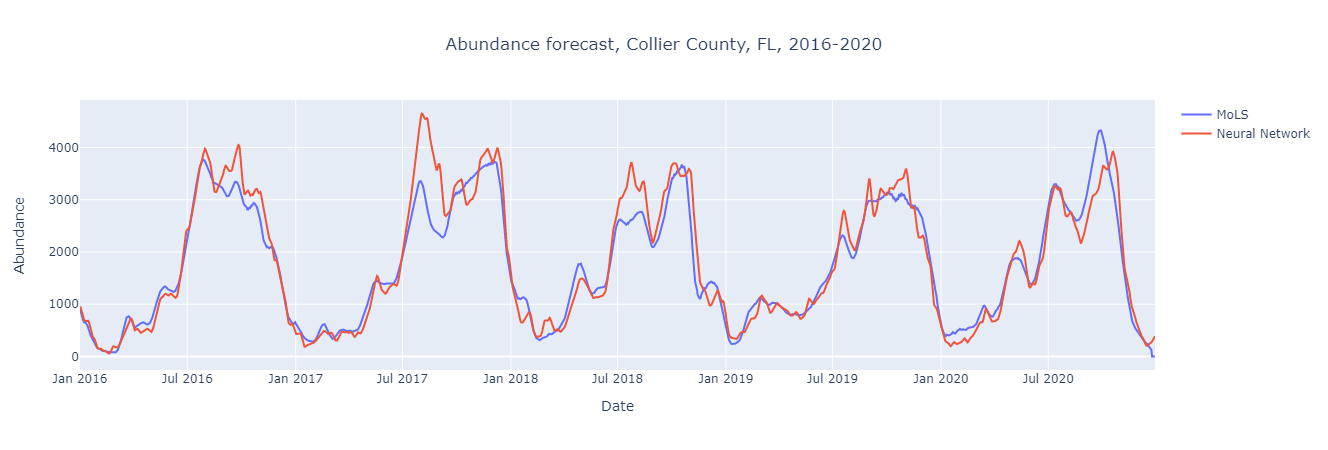

In [15]:
data_file="./results/Test_set_predictions.csv"
data=pd.read_csv(data_file)
data=data[data.Location=='Collier,Florida']
data=data[data.Year>2015]


#set x-axis to be datetimes
x_data=np.arange(datetime(int(data.iloc[0,1]),int(data.iloc[0,2]),int(data.iloc[0,3])), 
                 datetime(int(data.iloc[-1,1]), int(data.iloc[-1,2]), int(data.iloc[-1,3])), 
                 timedelta(days=1)).astype(datetime)

trace = [go.Scatter(x=x_data,y=data["MoLS"],name="MoLS")]
trace.append(go.Scatter(x=x_data,y=data["Neural Network"],name="Neural Network"))
layout = go.Layout(title="Abundance forecast, Collier County, FL, 2016-2020", title_x=0.5, xaxis=dict(title="Date"),yaxis=dict(title="Abundance"))
fig=go.Figure(layout=layout, data=trace)
iplot(fig,filename='Collier_FL_2016_2020_forecast')
